In [1]:
# ATTENTION: Please do not alter any of the provided code in the exercise. Only add your own code where indicated
# ATTENTION: Please do not add or remove any cells in the exercise. The grader will check specific cells based on the cell position.
# ATTENTION: Please use the provided epoch values when training.

%matplotlib inline
import tensorflow as tf
from os import getcwd
print(tf.__version__)

2.8.2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path_daily_min_temperatures = '/content/drive/MyDrive/TF AND KERAS/Deeplearning.AI TensorFlow Developer Professional Certificate/Sequences, Time Series and prediction/daily-min-temperatures.csv'

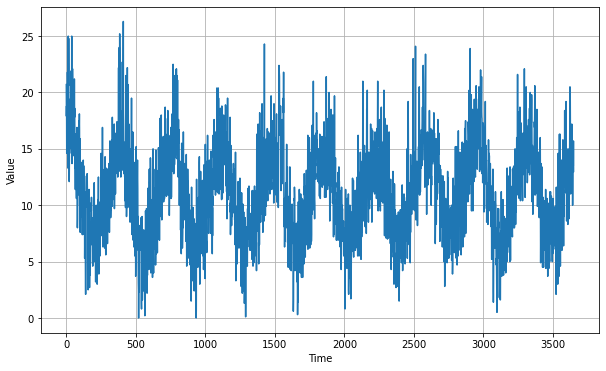

In [8]:
import csv

time_step = []
temps = []

with open(path_daily_min_temperatures) as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    time_s = 0
    for row in reader:
        time_step.append(int(time_s))
        temps.append(float(row[1]))
        time_s += 1

# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [9]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w:(w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
    # YOUR CODE HERE

In [11]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.batch(32).prefetch(1)
    return model.predict(ds)
    # YOUR CODE HERE

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=5, padding='causal', strides=1, activation='relu', input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 25)
# YOUR CODE HERE
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(2500,)
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


10/10 [==============================] - 17s 65ms/step - loss: 11.3864 - mae: 11.8858 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 32ms/step - loss: 11.3702 - mae: 11.8696 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 32ms/step - loss: 11.3453 - mae: 11.8447 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 30ms/step - loss: 11.3151 - mae: 11.8144 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 0s 30ms/step - loss: 11.2802 - mae: 11.7795 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 30ms/step - loss: 11.2407 - mae: 11.7400 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 0s 30ms/step - loss: 11.1962 - mae: 11.6954 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 0s 32ms/step - loss: 11.1458 - mae: 11.6450 - lr: 2.2387e-08
Epoch 9/100
10/10 [==============================] - 0s 30ms/step - loss: 11.0891 - mae: 11.5883 - 

(1e-08, 0.001, 0.0, 60.0)

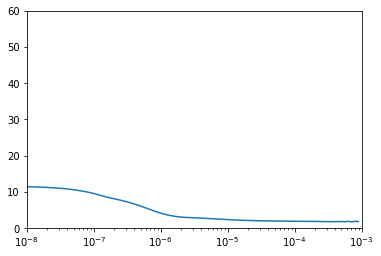

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 60])

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=32, batch_size=50, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=60, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 25)
# YOUR CODE HERE
])


optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
50/50 [==============================] - 4s 15ms/step - loss: 3.3977 - mae: 3.8673
Epoch 2/150
50/50 [==============================] - 1s 12ms/step - loss: 2.1705 - mae: 2.6266
Epoch 3/150
50/50 [==============================] - 1s 12ms/step - loss: 1.9787 - mae: 2.4327
Epoch 4/150
50/50 [==============================] - 1s 19ms/step - loss: 1.9360 - mae: 2.3898
Epoch 5/150
50/50 [==============================] - 1s 12ms/step - loss: 1.9040 - mae: 2.3575
Epoch 6/150
50/50 [==============================] - 1s 12ms/step - loss: 1.8729 - mae: 2.3260
Epoch 7/150
50/50 [==============================] - 1s 12ms/step - loss: 1.8511 - mae: 2.3041
Epoch 8/150
50/50 [==============================] - 1s 12ms/step - loss: 1.8276 - mae: 2.2801
Epoch 9/150
50/50 [==============================] - 1s 12ms/step - loss: 1.8133 - mae: 2.2651
Epoch 10/150
50/50 [==============================] - 1s 12ms/step - loss: 1.7904 - mae: 2.2418
Epoch 11/150
50/50 [=============================

In [15]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

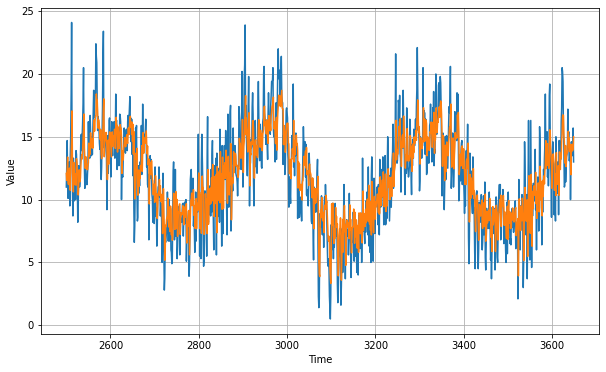

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [22]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7832417

In [23]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[12.074934 11.534676 12.50287  ... 13.928327 13.95717  15.0021  ]
